<a href="https://colab.research.google.com/github/JDS1975/M-todos-supervisados/blob/main/20222_M2_855_PEC3_Enunciado.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<div style="width: 100%; clear: both;">
<div style="float: left; width: 50%;">
<img src="http://www.uoc.edu/portal/_resources/common/imatges/marca_UOC/UOC_Masterbrand.jpg", align="left">
</div>
<div style="float: right; width: 50%;">
<p style="margin: 0; padding-top: 22px; text-align:right;">M2.855 · Modelos avanzados de minería de datos</p>
<p style="margin: 0; text-align:right;">2022-2 · Máster universitario en Ciencia de datos (<i>Data science</i>)</p>
<p style="margin: 0; text-align:right; padding-button: 100px;">Estudios de Informática, Multimedia y Telecomunicación</p>
</div>
</div>
<div style="width:100%;">&nbsp;</div>

# PEC 3: Métodos supervisados

En esta práctica veremos diferentes métodos supervisados y trataremos de optimizar diferentes métricas. Veremos como los diferentes modelos clasifican los puntos y con cuales obtenemos mayor precisión. Después aplicaremos todo lo que hemos aprendido hasta ahora a un dataset nuevo simulando un caso práctico real.

1. [Exploración de algoritmos supervisados](#eje1) \
    1.0. Carga de datos \
    1.1. Naive-Bayes\
    1.2. Análisis Discriminante Lineal (LDA) y Análisis Discriminante Cuadrtático (QDA)\
    1.3. K vecinos más próximos (KNN)\
    1.4. Máquinas de soporte vectorial (SVM)\
    1.5. Árboles de decisión
2. [Implementación del caso práctico](#ej2)\
    2.0. Carga de datos\
    2.1. Análisis descriptivo\
    2.2. Entrenamiento, validación y prueba de una red neuronal con los datos originales\
    2.3. Submuestreo\
    2.4. Sobremuestreo\
    2.5. Generación de datos sintéticos\
    2.6. Sintonizando los modelos (BONUS)

<u>Consideraciones generales</u>: 

- La solución planteada no puede utilizar métodos, funciones o parámetros declarados **_deprecated_** en futuras versiones, a excepción de la carga de datos cómo se indica posteriormente.
- Esta PEC debe realizarse de forma **estrictamente individual**. Cualquier indicio de copia será penalizado con un suspenso (D) para todas las partes implicadas y la posible evaluación negativa de la asignatura de forma íntegra.
- Es necesario que el estudiante indique **todas las fuentes** que ha utilizado para la realización de la PEC. De no ser así, se considerará que el estudiante ha cometido plagio, siendo penalizado con un suspenso (D) y la posible evaluación negativa de la asignatura de forma íntegra.

<u>Formato de la entrega</u>:

- Algunos ejercicios pueden suponer varios minutos de ejecución, por lo que la entrega debe hacerse en **formato notebook** y en **formato html**, donde se vea el código, los resultados y comentarios de cada ejercicio. Se puede exportar el notebook a HTML desde el menú File $\to$ Download as $\to$ HTML.
- Existe un tipo de celda especial para albergar texto. Este tipo de celda os será muy útil para responder a las diferentes preguntas teóricas planteadas a lo largo de la actividad. Para cambiar el tipo de celda a este tipo, en el menú: Cell $\to$ Cell Type $\to$ Markdown.

<div class="alert alert-block alert-info">
    <strong>Nombre y apellidos:</strong>
</div>

In [10]:
import numpy as np 
import pandas as pd
import seaborn as sns

from sklearn import datasets
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.utils import check_random_state

# Visualizar árboles
from IPython.display import Image
import pydotplus
from six import StringIO

# Visualización.
import matplotlib as mpl
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt

%matplotlib inline

<a id='ej1'></a>
# 1. Exploración de algoritmos supervisados

## 1.0. Carga de datos

El conjunto de datos Spiral es un conjunto de datos sintéticos que se utiliza comúnmente en el aprendizaje automático y la minería de datos como un problema de clasificación no lineal. El conjunto de datos consta de dos espirales entrelazadas que se asemejan a las espirales de Arquímedes. Cada espiral se compone de un conjunto de puntos distribuidos uniformemente en el plano, y los puntos de cada espiral están etiquetados con una clase diferente.

El objetivo es utilizar un algoritmo de clasificación para predecir la clase de un punto desconocido en función de sus coordenadas (x, y). Debido a la naturaleza entrelazada de las espirales, este problema de clasificación es no lineal y, por lo tanto, es un desafío interesante para los algoritmos de aprendizaje automático.

El siguiente código cargará 2000 puntos en la variable `X` y la correspondientes etiqueta o grupo (en forma numérica) en la variable `y`. Podemos comprobar que la carga ha sido correcta obteniendo las dimensiones de estas dos variables y el gráfico de los puntos (con colores diferentes para cada grupo).

Dimensiones de X (2000, 2)
Dimensiones de y (2000,)


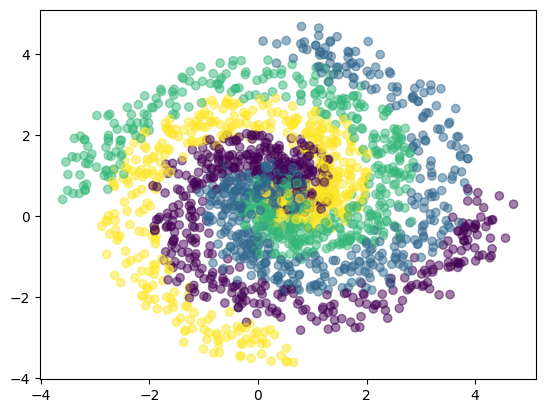

In [11]:
data = pd.read_pickle('spiral.pickle')

# Convertir las dos primeras columnas en un array de numpy
X = data[['X1', 'X2']].values

# Convertir la última columna en un array de numpy
y = data['y'].values

print('Dimensiones de X', X.shape)
print('Dimensiones de y', y.shape)

# Hacer la representación gráfica
plt.scatter(X[:,0], X[:,1], c=y, cmap=plt.cm.viridis, alpha=0.5)
plt.show()

In [65]:
data.head()

,X1,X2,y
0,-0.723086,1.398472,0.0
1,1.638987,-0.543341,2.0
2,0.438198,0.363253,2.0
3,-0.461198,0.487286,1.0
4,-1.542407,-1.875442,3.0


In [72]:
data.groupby(['y']).size()

y
0.0    500
1.0    500
2.0    500
3.0    500
dtype: int64

De cada categoría tenemos 500 observaciones. Como podemos ver tenemos 4 categorias en la varoable "y"

A lo largo de los ejercicios aprenderemos a ver gráficamente las fronteras de decisión que nos devuelven los diferentes modelos. Para ello utilizaremos la función definida a continuación, que sigue los siguientes pasos:

   - Crear una [meshgrid](https://docs.scipy.org/doc/numpy/reference/generated/numpy.meshgrid.html) con los valores mínimo y máximo de 'x' e 'y'.
   - Predecir el clasificador con los valores de la _meshgrid_.
   - Hacer un _reshape_ de los datos para tener el formato correspondiente.
  
Una vez hecho esto, ya podemos hacer el gráfico de las fronteras de decisión y añadir los puntos reales. Así veremos las áreas que el modelo considera que son de una clase y las que considera que son de otra. Al poner encima los puntos veremos si los clasifica correctamente en el área que les corresponde.

In [66]:
def plot_decision_boundary(clf, X, Y, cmap='Paired'):
    if not isinstance(X, np.ndarray):  # Si X no es un array de numpy, lo convierte
        X = X.to_numpy()
    
    h = 0.02
    x_min, x_max = X[:,0].min() - 10*h, X[:,0].max() + 10*h
    y_min, y_max = X[:,1].min() - 10*h, X[:,1].max() + 10*h
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.figure(figsize=(7,7))
    plt.contourf(xx, yy, Z, cmap=cmap, alpha=0.25)
    plt.contour(xx, yy, Z, colors='k', linewidths=0.7)
    plt.scatter(X[:,0], X[:,1], c=Y, cmap=cmap, edgecolors='k', label=Y);

<div class="alert alert-block alert-info">
    <strong>Implementación:</strong> 

Dividid el _dataset_ en dos subconjuntos, __*train*__ (80% de los datos) y __*test*__ (20% de los datos). Nombrad los conjuntos como: X_train, X_test, y_train, y_test. Utilizad la opción `random_state = 24`.
    
Podéis utilizar la implementación `train_test_split` de `sklearn`.
    
</div>

<div class="alert alert-block alert-danger">
<strong>Solución:</strong>
</div>

In [47]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=.8, random_state=24) 


### 1.1. Gaussian Naïve Bayes

El objetivo de este primer ejercicio es entender el funcionamiento del algoritmo Naïve-Bayes, un algoritmo peculiar ya que se basa en el teorema de Bayes para calcular la probabilidad de que una observación pertenezca a cada una de las clases. El modelo asume que las características de entrada son independientes entre sí, lo que permite simplificar el cálculo de las probabilidades condicionales.

<div class="alert alert-block alert-info">
<strong>Implementación:</strong> 

- Con el dataset de _train_, entrenad un modelo de Naïve-Bayes. Podéis utilizar el clasificador `GaussianNB` de `sklearn`.

- Calculad el _accuracy_ del modelo obtenido sobre _train_ y _test_.

- Calculad la matriz de confusión sobre _test_.
    
- Representad gráficamente la frontera de decisión con el de _test_.
    
Podéis utilizar la función `plot_decision_boundary` creada previamente, y las funciones `accuracy_score` y `confusion_matrix` del paquet `metrics` de `sklearn`.
</div>

Entrenamiento del modelo.

In [73]:
clf = GaussianNB()
clf.fit(X_train, y_train)  
y_pred = clf.predict(X_test)


Exactitud del modelo

In [74]:
print("Exactitud:",accuracy_score(y_test, y_pred))

Exactitud: 0.2475


In [80]:
def matriz_confusion(model_fit, X_test, y_test, labels=['0', '1', '2', '3']):
    # Predicciones
    y_pred = model_fit.predict(X_test)
    
    # Matriz de confusuón
    mat = confusion_matrix(y_test, y_pred)

    # Representación gráfica matriz de confusuón
    ax = sns.heatmap(mat, square=True, annot=True, cbar=False, cmap='GnBu', fmt='d', linewidths=4)
    ax.invert_yaxis()
    ax.set_xticklabels(labels)
    ax.set_yticklabels(labels)
    plt.xlabel('Predicted Label');
    plt.ylabel('True Label')

    
  

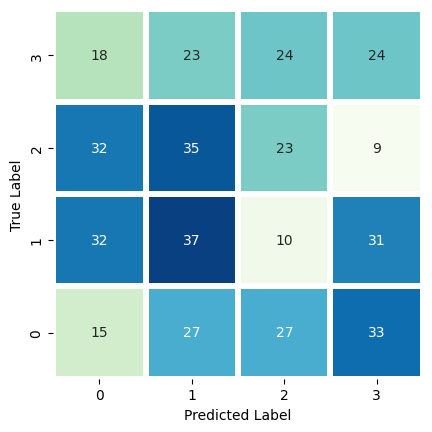

In [81]:
matriz_confusion(clf.fit(X_train,y_train), X_test, y_test)

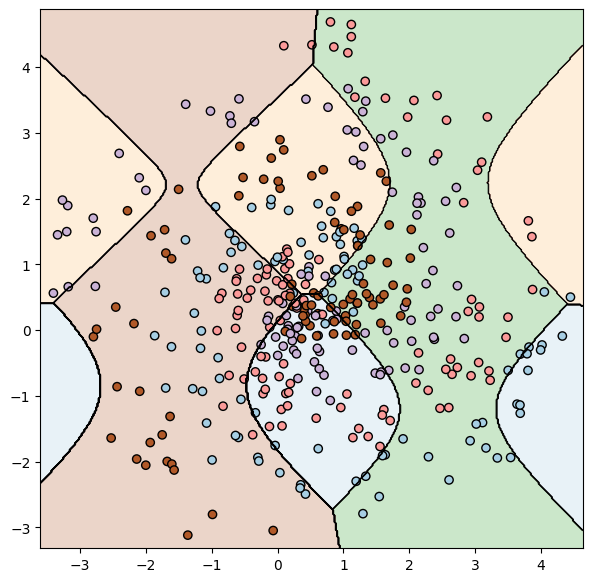

In [79]:
plot_decision_boundary(clf,X_test,y_test)

<div class="alert alert-block alert-info">
<strong>Análisis:</strong>

   - ¿Cómo son las fronteras de decisión? ¿Tiene sentido que tengan esta forma con el algoritmo utilizado?
   - ¿Cómo son las predicciones obtenidas sobre el conjunto de test?
</div>

<div class="alert alert-block alert-success">
<strong>Respuesta:</strong> 


</div>

### 1.2 Análisis Discriminante Lineal (LDA) y Análisis Discriminante Cuadrtático (QDA)

Ahora analizaremos dos algoritmos que se basan en la transformación lineal de las características de entrada para maximizar la separación entre las clases. Estos modelos suponen que las características tienen una distribución gaussiana y así poder calcular las probabilidades condicionales de cada clase y asignar la clase con la mayor probabilidad como la clase predicha para una observación dada. 

<div class="alert alert-block alert-info">
<strong>Implementación:</strong> 

- Con el dataset de _train_, entrenad un modelo de Análisis Discriminate Lineal (LDA). Podéis utilizar el clasificador `LinearDiscriminantAnalysis` de `sklearn`.

- Calculad el _accuracy_ del modelo obtenido sobre _train_ y _test_.

- Calculad la matriz de confusión sobre _test_.
    
- Representad gráficamente la frontera de decisión con el de _test_.

</div>

<div class="alert alert-block alert-danger">
<strong>Solución:</strong>
</div>

<div class="alert alert-block alert-info">
<strong>Análisis:</strong>

   - ¿Cómo son las fronteras de decisión? ¿Tiene sentido que tengan esta forma con el algoritmo utilizado?
   - ¿Cómo son las predicciones obtenidas sobre el conjunto de test?
</div>

<div class="alert alert-block alert-success">
<strong>Respuesta:</strong> 


</div>

<div class="alert alert-block alert-info">
<strong>Implementación:</strong> 

- Con el dataset de _train_, entrenad un modelo de Análisis Discriminate Cuadrático (QDA). Podéis utilizar el clasificador `QuadraticDiscriminantAnalysis` de `sklearn`.

- Calculad el _accuracy_ del modelo obtenido sobre _train_ y _test_.

- Calculad la matriz de confusión sobre _test_.
    
- Representad gráficamente la frontera de decisión con el de _test_.

</div>

<div class="alert alert-block alert-danger">
<strong>Solución:</strong>
</div>

<div class="alert alert-block alert-info">
<strong>Análisis:</strong> 

   - ¿Cómo son las fronteras de decisión? ¿Tiene sentido que tengan esta forma con el algoritmo utilizado?
   - ¿Cómo son las predicciones obtenidas sobre el conjunto de test?
   - ¿En que se diferencian el algoritmo LDA del QDA?
</div>

<div class="alert alert-block alert-success">
<strong>Respuesta:</strong> 


</div>

### 1.3. K- vecinos más próximos KNN

En este punto entenderemos el funcionamiento del algoritmo KNN (que se basa en la proximidad de los puntos de datos en un espacio de características), intuir sus principales ventajas o desventajas y entender la influencia de los parámetros de los que está compuesto.

K-Nearest-Neighbor es un algoritmo basado en instancia de tipo supervisado. 

Vamos a ver qué significa esto:

  - Supervisado: tenemos etiquetado nuestro conjunto de datos de entrenamiento, con la clase o resultado esperado.
  - Basado en instancia (_Lazy Learning_): Esto significa que nuestro algoritmo no aprende explícitamente un modelo (como por ejemplo en Regresión Logística o árboles de decisión), sino que memoriza las instancias de entrenamiento que son utilizadas como "conocimiento" para la fase de predicción.

¿Cómo funciona KNN?

  - Calculamos la distancia entre el ítem a clasificar y los demás ítems del dataset de entrenamiento.
  - Seleccionamos los "k" elementos más cercanos, es decir, con menor distancia, según la distancia que utilizamos (euclídea, coseno, manhattan, etc).
  - Por último realizamos una "votación de mayoría" entre los k puntos: los de la clase que "dominan" decidirán su clasificación final.

<div class="alert alert-block alert-info">
<strong>Implementación:</strong>

- Con el dataset de _train_, entrenad un clasificador KNN con hiperparámetro `n_neighbors=2`. Podéis utilizar el clasificador `KNeighborsClassifier` de `sklearn`.

- Calculad el _accuracy_ del modelo obtenido sobre _train_ y _test_.

- Calculad la matriz de confusión sobre _test_.
    
- Representad gráficamente la frontera de decisión con el de _test_.


Si al entrenar el clasificador sale un warning y lo quieres ignorar, ejecuta el siguiente código antes del entrenamiento:

`import warnings`\
`warnings.filterwarnings('ignore', message='^.*will change.*$', category=FutureWarning)`

</div>

<div class="alert alert-block alert-danger">
<strong>Solución:</strong>
</div>

In [ ]:
import warnings
warnings.filterwarnings('ignore', message='^.*will change.*$', category=FutureWarning)

En el modelo entrenado, hemos fijado el parámetro `n_neighbors` de forma arbitraria. Pero podría ser que con otro valor obtuviéramos una mejor predicción.

Para conocer el valor óptimo de los parámetros de un modelo (_hyperparameter tunning_) se suele utilizar una búsqueda de rejilla (_grid search_). Es decir, entrenar un modelo para cada combinación de hiperparámetros posible y evaluarlo utilizando validación cruzada (_cross validation_) con 5 particiones estratificadas. Posteriormente, se elige la combinación de hiperparàmetres que mejores resultados haya obtenido.

En este caso sólo queremos optimizar un hiperparámetro:

   - 𝑘: el número de vecinos que se consideran para clasificar un nuevo ejemplo. Probaremos con todos los valores entre 1 y 20.

<div class="alert alert-block alert-info">
    <strong>Implementación:</strong>

Cálculo del valor óptimo del hiperparámetro _k_ (`n_neighbors`). Utilizad una búsqueda de rejilla con validación cruzada para encontrar el valor óptimo de _k_. Por cada valor, calculad su promedio y la desviación estándar. Implementad un _heatmap_ para visualizar la precisión según los diferentes valores del hiperparámetro.
    
Puede utilizar el módulo `GridSearchCV` de `sklearn` el cálculo del mejor hiperparámetro, y `heatmap` de `Seaborn`.
</div>

<div class="alert alert-block alert-danger">
<strong>Solución:</strong>
</div>

<div class="alert alert-block alert-info">
<strong>Implementación:</strong>

- Con el dataset de _train_, entrenad un clasificador KNN con el mejor hiperparámetro encontrado. 

- Calculad el _accuracy_ del modelo obtenido sobre _train_ y _test_.

- Calculad la matriz de confusión sobre _test_.
    
- Representad gráficamente la frontera de decisión con el de _test_.
</div>

<div class="alert alert-block alert-danger">
<strong>Solución:</strong>
</div>

<div class="alert alert-block alert-info">
<strong>Análisis:</strong> 

   - Comentar los resultados de la búsqueda del mejor hiperparámetro.
   - ¿Cómo se visualiza gráficamente el cambio del valor `n_neighbors`? ¿Tiene sentido esta diferencia entre los dos gráficos al cambiar el parámetro?
   - ¿Cómo son las fronteras de decisión? ¿Tiene sentido que tengan esta forma con el algoritmo utilizado?
   - ¿Cómo son las predicciones obtenidas sobre el conjunto de test?
</div>

<div class="alert alert-block alert-success">
<strong>Respuesta:</strong> 


</div>

### 1.4. Máquinas de soporte vectorial SVM

Las Support Vector Machine (SVM) se fundamentan en el _Maximal Margin Classifier_, que a su vez, se basan en el concepto de hiperplano.

En un espacio p-dimensional, un hiperplano se define como un subespacio plano y afín de dimensiones p-1. El término afín significa que el subespacio no debe pasar por el origen. En un espacio de dos dimensiones, el hiperplano es un subespacio de 1 dimensión, es decir, una recta. En un espacio tridimensional, un hiperplano es un subespacio de dos dimensiones, un plano convencional. Para dimensiones p>3 no es intuitivo visualizar un hiperplano, pero el concepto de subespacio con p-1 dimensiones se mantiene.

La definición de hiperplano para casos perfectamente separables linealmente resulta en un número infinito de posibles hiperplanos, lo que hace necesario un método que permita seleccionar uno de ellos como clasificador óptimo.

La solución a este problema consiste en seleccionar como clasificador óptimo al que se conoce como _maximal margin hyperplane_ o hiperplano óptimo de separación, que se corresponde con el hiperplano que se encuentra más alejado de todas las observaciones de entrenamiento. Para obtenerlo, se debe calcular la distancia perpendicular de cada observación a un determinado hiperplano. La menor de estas distancias (conocida como margen) determina cómo de lejos está el hiperplano de las observaciones de entrenamiento. El _maximal margin hyperplane_ se define como el hiperplano que consigue un mayor margen, es decir, que la distancia mínima entre el hiperplano y las observaciones es lo más grande posible. Aunque esta idea suena razonable, no es posible aplicarla, ya que habría infinitos hiperplanos contra los que medir las distancias. En su lugar, se recurre a métodos de optimización.

El proceso de optimización tiene la peculiaridad de que sólo las observaciones que se encuentran justo al margen o que lo violan influyen sobre el hiperplano. A estas observaciones se les conoce como vectores soporte (_vectors suport_) y son las que definen el clasificador obtenido.

#### Los _kernels_ en SVM

Hay veces en que no hay manera de encontrar un hiperplano que permita separar dos clases. En estos casos decimos que las clases no son linealmente separables. Para resolver este problema podemos utilizar el truco del núcleo .

El truco del núcleo (_kernel trick_) consiste en utilizar una dimensión nueva en la que podamos encontrar un hiperplano para separar las clases. Se puede ver un un ejemplo en: https://www.youtube.com/watch?v=OdlNM96sHio

Al igual que en el algoritmo visto anteriormente (KNN), las SVM también dependen de varios hiperparámetros. 

En este caso intentaremos optimizar dos hiperparámetros:

  - **C**: es la regularización, es decir, el valor de penalización de los errores en la clasificación. Indica el compromiso entre obtener el hiperplano con el margen más grande posible y clasificar el máximo número de ejemplos correctamente. Probaremos los valores: 0.01, 0.1, 1, 10, 50, 100 y 200.
  
  - **Gama**: coeficiente que multiplica la distancia entre dos puntos en el kernel radial. Para decirlo a "grosso modo", cuanto más pequeño es gama, más influencia tienen dos puntos cercanos. Probaremos los valores: 0.001, 0.01, 0.1, 1 y 10.
  
Al igual que en el caso anterior, para validar el rendimiento del algoritmo con cada combinación de hiperparámetros utilizaremos validación cruzada (_cross-validation_) con 4 particiones estratificadas.

<div class="alert alert-block alert-info">
    <strong>Implementación:</strong> 

Cálcular del valor óptimo de los hiperparámetros _C_ y _gama_. Utilizad una búsqueda de rejilla con validación cruzada para encontrar los valores óptimos. Para cada combinación de valores, calcular su promedio y la desviación estándar. Haced un _heatmap_ para visualizar la precisión según los diferentes valores de los hiperparámetros.

Podéis utilizar el módulo `GridSearchCV` de `sklearn` el cálculo de los mejores hiperparámetros con el clasificador SVC (de `SVM` de `sklearn`), y `heatmap` de `Seaborn`.
</div>

<div class="alert alert-block alert-danger">
<strong>Solución:</strong>
</div>

<div class="alert alert-block alert-info">
<strong>Implementación:</strong>

- Con el dataset de _train_, entrenad un modelo de SVM con la mejor combinación de parámetros encontrada. 

- Calculad el _accuracy_ del modelo obtenido sobre _train_ y _test_.

- Calculad la matriz de confusión sobre _test_.
    
- Representad gráficamente la frontera de decisión con el de _test_.
</div>

<div class="alert alert-block alert-danger">
<strong>Solución:</strong>
</div>

<div class="alert alert-block alert-info">
<strong>Análisis:</strong>

   - Comentar los resultados de la búsqueda de los mejores hiperparámetros.
   - ¿Cómo son las fronteras de decisión? ¿Tiene sentido que tengan esta forma con el algoritmo utilizado?
   - ¿Cómo son las predicciones obtenidas sobre el conjunto de test?
</div>

<div class="alert alert-block alert-success">
<strong>Respuesta:</strong> 


</div>

### 1.5. Árboles de decisión

Los árboles de decisión son modelos predictivos formados por reglas binarias (si / no) con las que se consigue repartir las observaciones en función de sus atributos y predecir así el valor de la variable respuesta.

Los árboles pueden ser **clasificadores** (para clasificar clases, tales como nuestro ejemplo), o bien **regresores** (para predecir variables continuas).

#### Construcción de un árbol

La creación de las ramificaciones de los árboles se logra mediante el algoritmo de *recursive binary splitting*. Este algoritmo consta de tres pasos principales:

   - El proceso se inicia en lo alto del árbol, donde todas las observaciones pertenecen a la misma región.
   - Se identifican todos los posibles puntos de corte para cada uno de los predictores. Los puntos de corte son cada uno de sus niveles.
   - se evalúan las posibles divisiones de cada predictor de acuerdo a una determinada medida. En el caso de los clasificadores se utilizan: *classification error rate*, Gini, entropía, chi-square.

<div class="alert alert-block alert-info">
<strong>Implementación:</strong>

- Con el dataset de _train_, entrenad un arbol de desición. Podéis utilizar el clasificador `DecisionTreeClassifier` (de `tree` de `sklearn`).

- Calculad el _accuracy_ del modelo obtenido sobre _train_ y _test_.

- Calculad la matriz de confusión sobre _test_.
    
- Representad gráficamente la frontera de decisión con el de _test_. 
    
- Representad el árbol. Podéis utilizar el comando `plot.tree` de la biblioteca `tree` de `sklearn`.
</div>

<div class="alert alert-block alert-danger">
<strong>Solución:</strong>
</div>

<div class="alert alert-block alert-info">
<strong>Análisis:</strong> 

   - Comentad los resultados.

</div>

<div class="alert alert-block alert-success">
<strong>Respuesta:</strong> 


</div>

#### Evitando el *overfitting*

El proceso de construcción de árboles descrito tiende a reducir rápidamente el error de entrenamiento, por lo que generalmente el modelo se ajusta muy bien a las observaciones utilizadas como entrenamiento (conjunto de *train*). Como consecuencia, los árboles de decisión tienden al *overfitting*. 

Para prevenirlo, utilizaremos dos hiperparámetros:

   - `max_depth`: la profundidad máxima del árbol. Exploraremos los valores entre 4 y 10.
   - `min_samples_split`: el número mínimo de observaciones que debe tener una hoja del árbol para poder dividir. Exploraremos los valores: 2, 10, 20, 50 y 100.

<div class="alert alert-block alert-info">
    <strong>Implementación:</strong>

Calculad el valor óptimo de los hiperparámetros `max_depth` y `min_samples_split`. Utilizad una búsqueda de rejilla con validación cruzada para encontrar los valores óptimos. Para cada combinación de valores, calcular su promedio y la desviación estándar. Haced un _heatmap_ para visualizar la precisión según los diferentes valores de los hiperparámetros.
    
Pódeis utilizar el módulo `GridSearchCV` de `sklearn` el cálculo de los mejores hiperparámetros con el clasificador `DecisionTreeClassifier` (de `tree` de `sklearn`), y `heatmap` de `Seaborn`.
</div>

<div class="alert alert-block alert-danger">
<strong>Solución:</strong>
</div>

<div class="alert alert-block alert-info">
<strong>Implementación:</strong>

- Con el dataset de _train_, entrenad un árbol de desición con la mejor combinación de parámetros encontrada.

- Calculad el _accuracy_ del modelo obtenido sobre _train_ y _test_.

- Calculad la matriz de confusión sobre _test_.
    
- Representad gráficamente la frontera de decisión con el de _test_.
    
- Representad el árbol. 
    
</div>

<div class="alert alert-block alert-danger">
<strong>Solución:</strong>
</div>

<div class="alert alert-block alert-info">
<strong>Análisis:</strong>

   - Comentar los resultados de la búsqueda de los mejores hiperparámetros.
   - ¿Cómo son las fronteras de decisión? ¿Tiene sentido que tengan esta forma con el algoritmo utilizado?
   - ¿Cómo son las predicciones obtenidas sobre el conjunto de test?
</div>

<div class="alert alert-block alert-success">
<strong>Respuesta:</strong> 


</div>

<a id='ej2'></a>
# 2. Implementación del caso práctico (5 puntos)

Como experto en análisis de datos, sabemos la importancia de que las empresas de tarjetas de crédito puedan identificar y prevenir transacciones fraudulentas para proteger a sus clientes. En este sentido, estudiaremos un conjunto de datos que contiene información sobre transacciones realizadas con tarjetas de crédito en septiembre de 2013 por titulares de tarjetas europeos.

Este conjunto de datos presenta transacciones ocurridas en dos días, donde se registraron 492 casos de fraude de un total de 284,807 transacciones. Es importante destacar que todas las variables de entrada son numéricas y fueron obtenidas a través de una transformación PCA. Lamentablemente, debido a razones de confidencialidad, no se pueden proporcionar las características originales ni más información sobre los datos. Las variables V1 a V28 representan los componentes principales obtenidos con PCA, mientras que "Time" e "Amount" son las únicas variables que no han sido transformadas con PCA. La variable "Time" indica los segundos transcurridos entre cada transacción y la primera transacción del conjunto de datos, mientras que "Amount" representa el monto de la transacción. La variable "Class" es la variable de respuesta y toma el valor 1 en caso de fraude y 0 en caso contrario.

Fuente: https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud

## 2.0. Carga de datos

Lo primero que haremos será cargar el conjunto de datos, visualizar las primeras filas, y verificar:

- La cantidad total de filas y columnas en el DataFrame.
- El nombre de cada columna del DataFrame.
- El número de valores no nulos en cada columna.
- El tipo de datos de cada columna, que puede ser int, float, object, entre otros.
- La cantidad de memoria utilizada por el DataFrame.

In [ ]:
import numpy as np 
import pandas as pd
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
data = pd.read_csv('https://storage.googleapis.com/download.tensorflow.org/data/creditcard.csv')
data.head()

In [ ]:
data.info()

## 2.1. Preprocesado de datos y análisis exploratorio

El preprocesado y análisis exploratorio de los datos es un paso crítico y fundamental en cualquier proyecto de análisis de datos o de aprendizaje automático. Ayuda a los investigadores a comprender mejor los datos, descubrir patrones y relaciones, identificar problemas y seleccionar las técnicas de análisis adecuadas para el conjunto de datos

<div class="alert alert-block alert-info">
<strong>Implementación:</strong> 

Calculad las frecuencias de la variable _target_ (`Class`) y haced un gráfico de barras.

<div class="alert alert-block alert-danger">
<strong>Solución:</strong>
</div>

<div class="alert alert-block alert-info">
<strong>Implementación:</strong> 

Analizar la distribución de las variables descriptoras. Representa gráficamente el histograma de las 30 variables separándo las observaciones según la clase a la que pertenece. Organiza todos los histogramas en 10 filas y 3 columnas.
</div>

<div class="alert alert-block alert-danger">
<strong>Solución:</strong>
</div>

<div class="alert alert-block alert-info">
<strong>Análisis:</strong>

   - ¿Cómo es la relación de la frecuencias de la variable `Class`?
   - ¿Qué información nos proporcionan los histogramas?, ¿Existe otra forma de visualización que pudiera ser útil, en este caso?
</div>

<div class="alert alert-block alert-success">
<strong>Respuesta:</strong> 


</div>

<div class="alert alert-block alert-info">
<strong>Implementación:</strong>

Los datos en bruto presentan algunos problemas. En primer lugar, las columnas `Time` y `Amount` son demasiado variables para utilizarlas directamente. Eliminad la columna `Time` (ya que no está claro qué significa) y tomad el logaritmo de la columna `Amount` para reducir su rango.
    
Para evitar la indeterminación "log(0)", sumádle 1 céntimo de dolar (0.001) a la columna `Amount` antes de calcular el logaritmo. No olvidéis que finalmente tenéis que reemplazar la columna `Amount` por `Log Amount`
</div>

<div class="alert alert-block alert-danger">
<strong>Solución:</strong>
</div>

<div class="alert alert-block alert-info">
<strong>Implementación:</strong>

- Separad los descriptores de la respuesta. Nombrad los conjuntos como: X, y.

- Dividid el _dataset_ en dos subconjuntos, __*train*__ (80% de los datos) y __*test*__ (20% de los datos). Nombrad los conjuntos como: X_train, X_test, y_train, y_test. Podéis utlizar la función `train_test_split`de la biblioteca `model_selection`de `sklearn`. Utilizad la opción `random_state = 24` y aseguraros que la división sea estratificada, es decir, que se mantenga la misma proporción de clases tanto en el conjunto de entrenamiento como en el de prueba.

Tened en cuenta que la matrices de las clases `y_train` e `y_test` deben estar codificadas. La función `to_categorical` de la librería `TensorFlow` de `Keras` se utiliza para convertir una matriz de etiquetas de clase (enteros) en una matriz de etiquetas de clase codificadas en one-hot.

La codificación one-hot es un proceso mediante el cual las etiquetas categóricas se convierten en vectores binarios, donde cada vector tiene una longitud igual al número de clases. Cada vector tiene un valor de 1 en la posición correspondiente a la clase y un valor de 0 en todas las demás posiciones. Esto se hace para permitir que los modelos de aprendizaje automático comprendan mejor la estructura de las etiquetas categóricas.  
</div>

<div class="alert alert-block alert-danger">
<strong>Solución:</strong>
</div>

<div class="alert alert-block alert-info">
<strong>Implementación:</strong>

- Normalizad los descriptores utilizando `StandardScaler`de `sklearn`. 
- Mostrad las dimensiones del conjunto de descriptores original, del conjunto de entrenamiento y del conjunto de prueba.
    
<strong>Nota:</strong> Recordad que el `StandardScaler` sólo se ajusta utilizando los descriptores de entrenamiento para evitar fugas de información o "data leakage". La fuga de información se produce cuando se utiliza información de los datos de prueba o validación para ajustar el modelo. En otras palabras, si se ajusta el modelo de escalado con todo el conjunto de datos, se estaría utilizando información de prueba o validación para el ajuste, lo que podría hacer que el modelo parezca más preciso de lo que realmente es.

</div>

<div class="alert alert-block alert-danger">
<strong>Solución:</strong>
</div>

## 2.2. Entrenamiento, validación y prueba de una red neuronal con los datos originales

Como herramienta de clasificación que nos permita predecir si una transacción es fraudulenta o no, utilizaremos un perceptrón multicapa. Un perceptrón multicapa (MLP, por sus siglas en inglés) es una red neuronal artificial compuesta por múltiples capas de unidades de procesamiento (neuronas), donde cada capa está conectada a la siguiente capa a través de un conjunto de conexiones ponderadas. El MLP es capaz de realizar tanto tareas de clasificación como de regresión al aprender a mapear las entradas a las salidas deseadas a través de una función de activación no lineal. La red utiliza un algoritmo de aprendizaje supervisado que ajusta los pesos de las conexiones durante el entrenamiento para minimizar la diferencia entre las salidas producidas por la red y las salidas deseadas. Debido a su capacidad para modelar relaciones no lineales complejas, el MLP es uno de los modelos más utilizados en el campo del aprendizaje automático.

Crearemos y entrenaremos una red Perceptrón Multicapa (MLP) con 4 capas ocultas de 20 neuronas cada una y con función de activación `relu`. Usaremos la clase `Sequential` de la libreria `keras`para crear el modelo de forma secuencial, es decir, apilando capas una encima de la otra. `Sequential` es la forma más sencilla de crear modelos de redes neuronales en `keras`, ya que no requiere definir la dirección del grafo computacional como ocurre en otros tipos de modelos más complejos.


<div class="alert alert-block alert-info">
<strong>Implementación:</strong>

- Cread el modelo `Sequential`. Agregad las 4 capas ocultas con 20 neuronas cada una utilizando el método `.add()` y función de activación `relu`. Agregad la capa de salida con 2 neuronas de salida (una para la clase 0 y la otra para la clase 1) y función de activación `sigmoid`. Mostrad el resumen de la red creada con el método `.summary()`
- Compilad el modelo utilizando el método `.compile()`, especificando el optimizador `adam`, la función de pérdida `binary_crossentropy` y las métrica de evaluación `accuracy`.
- Entrenad el modelo utilizando el método `.fit()` con `X_train`, especificad el número de épocas en 100 y el tamaño del lote en 2048. Validad su rendimiento haciendo validación cruzada con el 80% de los datos para el entrenamiento. Configura el parámetro `validation_split=0.2`.
- Graficad la pérdida (`loss`) tanto de entrenamiento como de validación en función de las épocas.
- Graficad la exactitud (`accuracy`) tanto de entrenamiento como de validación en función de las épocas.
    
<strong>Nota:</strong> Para la presentación del informe, configurad el parámetro `verbose=0`, para evitar mostrar información durante el entreno.
    
</div>

<div class="alert alert-block alert-danger">
<strong>Solución:</strong>
</div>

Una vez entrenado y validado el modelo, procederemos a hacer la prueba, es decir, predecir la clase de `X_test`y calcular las medidas de rendimiento

<div class="alert alert-block alert-info">
<strong>Implementación:</strong>

- Predecid la clase de `X_test`, calculad la exacitud de la predicción.
- Calculad la matriz de confusión
    
</div>

<div class="alert alert-block alert-danger">
<strong>Solución:</strong>
</div>

<div class="alert alert-block alert-info">
<strong>Análisis:</strong>

   - ¿Qué opinas de los resultados?, ¿nos podemos quedar con este modelo como aceptable?
   - ¿Las medidas de rendimiento usadas son aceptables? ¿Que otra medida de rendimiento propondrías?
</div>

<div class="alert alert-block alert-success">
<strong>Respuesta:</strong> 


</div>

## 2.3. Submuestreo

El submuestreo se refiere a la técnica de reducir el número de muestras de la clase mayoritaria para equilibrar la distribución de clases en un conjunto de datos.  Esto se puede lograr eliminando aleatoriamente muestras de la clase mayoritaria.

<div class="alert alert-block alert-info">
<strong>Implementación:</strong>

- Reduce el número de observaciones de la clase mayoritaria del conjunto de datos `X_train` hasta que tenga el mismo número de observaciones que la clase minoritaria. Muestra las dimensiones de las nuevas matrices de entrenamiento i la frecuencia de cada clase. Podéis utilizar la fución `resample` dela bibioteca `utils` de `sklearn`
- Cread, entrenad, graficad las pérdidas y exactitud durante el entreno, validad y probad otro modelo `Sequential` con la misma configuración del apartado anterior.
</div>

<div class="alert alert-block alert-danger">
<strong>Solución:</strong>
</div>

<div class="alert alert-block alert-info">
<strong>Análisis:</strong>

- ¿Porqué crees que se ha hecho un remuestreo solo a los datos de entrenamiento?
- ¿Qué opinas de los resultados?, ¿nos podemos quedar con este modelo como aceptable?
    
</div>

<div class="alert alert-block alert-success">
<strong>Respuesta:</strong> 


</div>

## 2.4. Sobremuestreo

Al contrario que el caso anterior, el sobremuestreo se refiere a la técnica de aumentar el número de muestras de la clase minoritaria para equilibrar la distribución de clases en un conjunto de datos. Esto se puede lograr mediante la replicación de muestras existentes o mediante la generación de muestras sintéticas de las clases minoritarias

<div class="alert alert-block alert-info">
<strong>Implementación:</strong>

- Aumenta el número de observaciones de la clase minoritaria del conjunto de datos `X_train` hasta que tenga el mismo número de observaciones que la clase mayoritaria. Muestra las dimensiones de las nuevas matrices de entrenamiento i la frecuencia de cada clase. 
- Cread, entrenad, , graficad las pérdidas y exactitud durante el entreno, validad y probad otro modelo `Sequential` con la misma configuración del apartado anterior.
</div>

<div class="alert alert-block alert-danger">
<strong>Solución:</strong>
</div>

<div class="alert alert-block alert-info">
<strong>Análisis:</strong>

   - ¿Porqué crees que se ha hecho un remuestreo solo a los datos de entrenamiento?
   - ¿Qué opinas de los resultados?, ¿nos podemos quedar con este modelo como aceptable?
</div>

<div class="alert alert-block alert-success">
<strong>Respuesta:</strong> 


</div>

## 2.5. Generación de datos sintéticos

SMOTE (Synthetic Minority Over-sampling Technique) es una técnica de sobremuestreo utilizada en el aprendizaje automático para abordar el problema de clases desequilibradas. SMOTE se utiliza para aumentar el número de muestras de la clase minoritaria al generar nuevas muestras sintéticas.

La técnica SMOTE funciona de la siguiente manera: Para cada muestra en la clase minoritaria, SMOTE selecciona k vecinos cercanos y crea nuevas muestras en el espacio entre la muestra y sus vecinos. Estas nuevas muestras sintéticas son agregadas al conjunto de datos para aumentar el número de muestras de la clase minoritaria.

La técnica SMOTE se utiliza en combinación con otras técnicas de preprocesamiento, como el submuestreo y la validación cruzada estratificada, para abordar el problema de clases desequilibradas en problemas de clasificación. Esta técnica puede mejorar la capacidad del modelo para aprender patrones de las clases minoritarias y puede aumentar el rendimiento en la clasificación de clases minoritarias.

<div class="alert alert-block alert-info">
<strong>Implementación:</strong>

- Mediante la técnica SMOTE, aumenta el número de observaciones de la clase minoritaria de todo el conjunto de datos `X`. Puedes utilizar la función`SMOTE` de la librería `over_sampling` de la bibioteca `imblearn` .  Muestra las dimensiones de las nuevas matrices de entrenamiento y la frecuencia de cada clase. 
- Cread, entrenad, graficad las pérdidas y exactitud durante el entreno, validad y probad otro modelo `Sequential` con la misma configuración del apartado anterior.
</div>

<div class="alert alert-block alert-danger">
<strong>Solución:</strong>
</div>

<div class="alert alert-block alert-info">
<strong>Análisis:</strong>

   - ¿Porqué crees que en este caso si se puede hacer el remuestreo a todo el conjunto de datos?
   - ¿Qué opinas de los resultados?, ¿Este es mejor que el anterior modelo? ¿nos podemos quedar con este modelo como aceptable?
   - Enfocándonos en las variables descriptoras, ¿cómo crees que se puede mejorar la predicción?
</div>

<div class="alert alert-block alert-success">
<strong>Respuesta:</strong> 


</div>

## 2.6. Sintonizando los modelos (BONUS)

Los modelos anteriores se han configurado con hiperparámetros elegidos arbitrariamente y puede que no genere el modelo con el mejor rendimiento.  La búsqueda de hiperparámetros óptimos es importante porque permite encontrar la combinación de parámetros que maximiza el rendimiento del modelo en los datos de prueba o validación, lo que a su vez proporciona un modelo más generalizable y preciso para nuevos datos.

<div class="alert alert-block alert-info">
<strong>Implementación:</strong>

- Mediante la función `GridSearchCV` de `sklearn.model_selection` y la función `KerasClassifier` de `keras.wrappers.scikit_learn`, encuentra los hiperparámetros óptimos para los modelos con los conjunto de datos: submuestreado, sobremuestreado y con generación sintética por medio de SMOTE. 
</div>

<div class="alert alert-block alert-danger">
<strong>Solución:</strong>
</div>